# Transforming time series with aeon

Transformers are objects that transform data from one representation to another. `aeon`
contains time series specific transformers which can be used in
pipelines in conjunction with other estimators.
Note: the term "transformer" is used in deep learning to refer to specific neural
network architectures. `aeon` transformers follow the `scikit-learn` design: they
have `fit`, `transform` and `fit_transform`  methods that combine the two functions.
Some transformers also have `inverse_transform` that allows you to reverse the change.

`aeon` distinguishes different types of transformer, depending on the input type accepted
by the `fit` and `transform` methods. The main distinction is whether all series types
(i.e. single time series, collections of time series, hierarchical time series) are accepted
and implicitly converted, or whether only a singular input type (i.e. collections) is accepted.

## Transformers

General transformers (in the package `aeon/transformations`, `aeon/transformations`,
`aeon/transformations/bootstrap` and `aeon/transformations/hierarchical`) aim to
accept all input types, and will attempt to restructure the data or broadcast to multiple transformer
objects if necessary to fit the input data to the data structure used by the transformer. For example,
if the class excepts a singular series but is given a collection of series, a separate instance of the
transformer is applied independently to each series. Transformers all extend the base class
`BaseTransformer`. General transformations are mostly used for single series tasks such as forecasting
and annotation, and are best used with `pd.Series` or `pd.DataFrame` input. Other valid data types will
be accepted but are likely to be converted to another format internally, see the
[data structures](../datasets/data_structures.ipynb) notebook for clarification of how
best
to store
data with aeon.

Transformers differ in terms of whether they convert time series into different time series
(series-to-series transformation), or whether they convert series into feature vector(s)
(series-to-vector transformation).

To illustrate the difference, we compare two single-series transformers with different output:

* the Box-Cox transformer `BoxCoxTransformer`, a series-to-series transformer using the
[Box Cox power transform](https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation).
* the summary transformer `SummaryTransformer`, a series-to-vector transformer that
finds summary statistics such as the mean an standard deviation of each series.


In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from aeon.datasets import load_airline
from aeon.transformations.boxcox import BoxCoxTransformer
from aeon.transformations.summarize import SummaryTransformer
from aeon.visualisation import plot_series

boxcox_trans = BoxCoxTransformer()
summary_trans = SummaryTransformer()

# airline is a single time series stored in a pd.Series
airline = load_airline()

type(airline)

pandas.core.series.Series

In [3]:
airline[:5]

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
Freq: M, Name: Number of airline passengers, dtype: float64

(<Figure size 1152x288 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

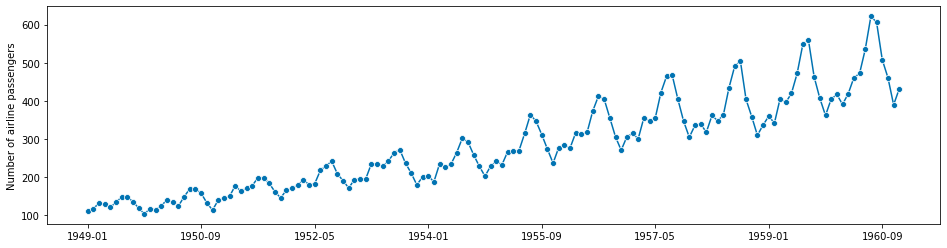

In [4]:
plot_series(airline)

In [5]:
# this produces a pandas Series containing the transformed series
airline_bc = boxcox_trans.fit_transform(airline)
type(airline_bc)

pandas.core.series.Series

In [6]:
airline_bc[:5]

Period
1949-01    6.827490
1949-02    6.932822
1949-03    7.161892
1949-04    7.114611
1949-05    6.983787
Freq: M, dtype: float64

(<Figure size 1152x288 with 1 Axes>, <Axes: >)

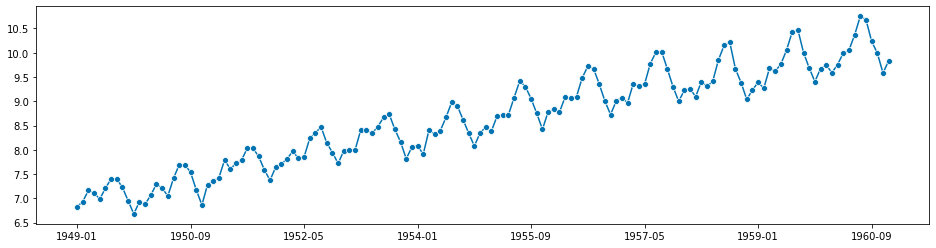

In [7]:
plot_series(airline_bc)

In [8]:
# this produces a pandas.DataFrame containing the feature vector for our single series
airline_summary = summary_trans.fit_transform(airline)
type(airline_summary)

pandas.core.frame.DataFrame

In [9]:
airline_summary

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
0,280.298611,119.966317,104.0,622.0,135.3,180.0,265.5,360.5,453.2


You can get a list of all series-to-series and series-to-vector transformers using
the output tags. Please consult the API for details on each transformations

In [10]:
from aeon.registry import all_estimators

all_estimators(
    "transformer",
    exclude_estimator_types="collection-transformer",
    filter_tags={
        "output_data_type": ["Series", "Collection"],
    },
    as_dataframe=True,
)

,name,estimator
0,Aggregator,<class 'aeon.transformations.hierarchical.aggr...
1,AutoCorrelationTransformer,<class 'aeon.transformations.acf.AutoCorrelati...
2,BKFilter,<class 'aeon.transformations.bkfilter.BKFilter'>
3,BoxCoxTransformer,<class 'aeon.transformations.boxcox.BoxCoxTran...
4,ClaSPTransformer,<class 'aeon.transformations.clasp.ClaSPTransf...
...,...,...
56,TimeSince,<class 'aeon.transformations.time_since.TimeSi...
57,TransformerPipeline,<class 'aeon.transformations.compose.Transform...
58,WhiteNoiseAugmenter,<class 'aeon.transformations.augmenter.WhiteNo...
59,WindowSummarizer,<class 'aeon.transformations.summarize.WindowS...


In [11]:
all_estimators(
    "transformer",
    exclude_estimator_types="collection-transformer",
    filter_tags={
        "output_data_type": "Tabular",
    },
    as_dataframe=True,
)

,name,estimator


If your series is split into training and testing data, you should call `fit` and
`transform` separately. `BoxCoxTransformer` has a parameter `lambda` that can be
learned from the train data:

In [12]:
from aeon.forecasting.model_selection import temporal_train_test_split

train, test = temporal_train_test_split(airline)
boxcox = BoxCoxTransformer(method="mle")
test[:5]

Period
1958-01    340.0
1958-02    318.0
1958-03    362.0
1958-04    348.0
1958-05    363.0
Freq: M, Name: Number of airline passengers, dtype: float64

You can then apply the model without refitting lambda using just `transform`:

In [13]:
# fit the transformer on the training data
boxcox.fit(train)
# apply to test data
test_new = boxcox.transform(test)
test_new[:5]

Period
1958-01    5.597723
1958-02    5.536036
1958-03    5.655489
1958-04    5.619156
1958-05    5.658029
Freq: M, dtype: float64

Fitted model components of transformers can be found with the `get_fitted_params()`
method:

In [14]:
boxcox.get_fitted_params()
# this is a pandas.DataFrame that contains the fitted transformers

{'lambda': -0.01398297802065717}

### Pipelines with transformers

Tasks such as forecasting are not compatible with `sklearn` pipelines, because `fit` and `predict`
are used differently and require different input. They can still be combined into `aeon` pipelines. The easiest
way to do this is with `make_pipeline`. Pipelines can be a combinations of
`BaseTransformer` objects, or a combination of `BaseTransformer` and estimators such
as forecasters, classifiers or regressors:

In [15]:
from aeon.forecasting.naive import NaiveForecaster
from aeon.pipeline import make_pipeline
from aeon.transformations.difference import Differencer

pipe = make_pipeline(Differencer(), NaiveForecaster(strategy="last", sp=12))

# this constructs a TransformedTargetForecaster, which is also a forecaster
pipe

TransformedTargetForecaster(steps=[Differencer(), NaiveForecaster(sp=12)])

In [16]:
# this is a forecaster with the same interface as NaiveForecaster
# first applies differencer, then naive forecaster, then inverts differencing
pipe.fit(airline, fh=list(range(1, 13)))
forecast = pipe.predict()
print(forecast)

1961-01    444.0
1961-02    418.0
1961-03    446.0
1961-04    488.0
1961-05    499.0
1961-06    562.0
1961-07    649.0
1961-08    633.0
1961-09    535.0
1961-10    488.0
1961-11    417.0
1961-12    459.0
Freq: M, dtype: float64


(<Figure size 1152x288 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

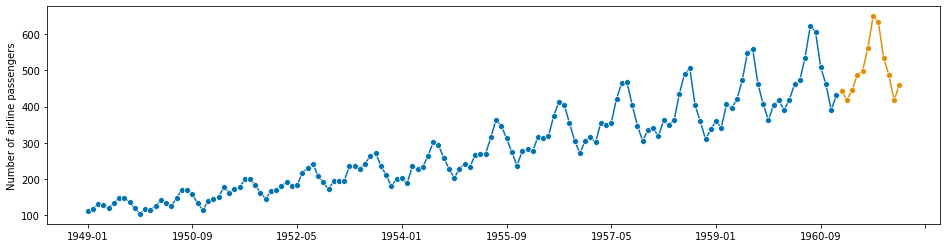

In [17]:
plot_series(airline, forecast)

In [18]:
from aeon.transformations.summarize import SummaryTransformer

trans_pipe = make_pipeline(Differencer(), SummaryTransformer())

trans_pipe

TransformerPipeline(steps=[Differencer(), SummaryTransformer()])

In [19]:
trans_pipe.fit_transform(airline)

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
0,2.222222,33.636569,-101.0,87.0,-37.7,-16.0,3.5,22.25,43.0


## Collection Transformers

Collection transformers inherit from `BaseCollectionTransformer`, itself a subclass
of `BaseTransformer`. Collection transformers differ from the other transformers in
`aeon` in that the only accept collections of series, and they are more likely to not
transform each series independently. A `BaseCollectionTransformer` works best with the same
data structures used by clusterers, regressors and classifiers: 3D numpy of shape
`(n_cases, n_channels, n_timepoints)` for equal length series or a list of 2D numpy `[n_cases]`.
 Like before, other valid collection input types can be used.
 See the [data storage notebook](../datasets/data_structures.ipynb) for more
 details.


In [20]:
from aeon.datasets import load_arrow_head, load_basic_motions, load_covid_3month

# univariate classification
arrows, arrows_labels = load_arrow_head()
# multivariate classification
motions, motions_labels = load_basic_motions()
# univariate regression
covid, covid_response = load_covid_3month()

print("Arrows shape (n_cases, n_channels, n_timepoints) = ", arrows.shape)
print("Motions shape (n_cases, n_channels, n_timepoints) = ", motions.shape)
print("Covid shape (n_cases, n_channels, n_timepoints) = ", covid.shape)

Arrows shape (n_cases, n_channels, n_timepoints) =  (211, 1, 251)
Motions shape (n_cases, n_channels, n_timepoints) =  (80, 6, 100)
Covid shape (n_cases, n_channels, n_timepoints) =  (201, 1, 84)


Collection transformers can also be series-to-series or series-to-vector. Most transformers will
always transform a collection of $n$ series into a collection of $n$ series or
vectors. For example, `Catch22` transforms each channel of each series into 22 summary features.


In [21]:
from aeon.transformations.collection.feature_based import Catch22

c22 = Catch22()
t = c22.fit_transform(arrows)
t.shape

(211, 22)

Series-to-series transformers transform each series into a different series. This can
 mean it has a different number of channels and/or be different length. For example,
 `ElbowClassPairwise` performs a supervised channel selection to reduce
 dimensionality. In the example below, it selects the best two channels from BasicMotions.

In [22]:
from aeon.transformations.collection import ElbowClassPairwise

ecp = ElbowClassPairwise()
t2 = ecp.fit_transform(motions, motions_labels)
t2.shape

(80, 2, 100)

series-to-vector Collection transformers return array-like objects of shape `(n_cases, n_features)`, so
they can be used with sklearn classifiers or regressors directly or in a pipeline. The following are equivalent.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

arrows_train, arrows_test, y_train, y_test = train_test_split(
    arrows, arrows_labels, test_size=0.33
)

c22 = Catch22()
c22_train = c22.fit_transform(arrows_train, y_train)

lr = LogisticRegression()
lr.fit(c22_train, y_train)

c22_test = c22.transform(arrows_test, y_test)
preds = lr.predict(c22_test)
accuracy_score(y_test, preds)

0.7285714285714285

In [24]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[("catch22", c22), ("logistic", lr)])
pipe.fit(arrows_train, y_train)
preds = pipe.predict(arrows_test)
accuracy_score(y_test, preds)

0.7285714285714285

Series-to-series collection transformers can be used in an sklearn pipeline with an
`aeon` classifier or regressor

In [25]:
from sklearn.metrics import mean_squared_error

from aeon.regression.distance_based import KNeighborsTimeSeriesRegressor

knn = KNeighborsTimeSeriesRegressor(distance="euclidean")
pipe = Pipeline(steps=[("ECP", ecp), ("knn", knn)])
covid_train, covid_test, y_train, y_test = train_test_split(
    covid, covid_response, test_size=0.75
)
pipe.fit(covid_train, y_train)

Pipeline(steps=[('ECP', ElbowClassPairwise()),
                ('knn', KNeighborsTimeSeriesRegressor(distance='euclidean'))])

In [26]:
preds = pipe.predict(covid_test)
mean_squared_error(y_test, preds)

0.0031265709032186895

### Wrapping a collection transformer to a series transformer

Collection transformers can be wrapped to have to same functionality as a `BaseTransformer` using the `CollectionToSeriesWrapper`.

In [27]:
from aeon.transformations.collection import CollectionToSeriesWrapper

c22 = Catch22()
wrapper = CollectionToSeriesWrapper(c22)  # wrap transformer to accept single series

wrapper.fit_transform(airline)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,155.800003,181.700012,49.0,0.541667,0.0,28.0,8.0,13651.400058,0.024544,48.183674,-4902.195804,0.675412,7.0,0.972028,5.0,1.50827,0.038462,0.118862,0.282051,0.769231,0.166667,11.0


### Broadcasting a series transformer to make a collection transformer

Given a series transformer, which inherit from the `BaseSeriesTransformer`, we can use the `BroadcastTransformer` to make it accept a collection of time series instead of a single time series as input.

Internaly, if the `BaseSeriesTransformer` used have a fit method, it will independently fit transformers for each series, otherwise, the same transformer will be used multiple times. For example given a collection `X` of shape `(n_cases, n_channels, n_timepoints)`, if the  `BaseSeriesTransformer` has a fit method, `n_cases` copies of it will be stored and fitted by `BroadcastTransformer`. These copies can be found in the `series_transformers` attribute of `BroadcastTransformer`.

This means that given `X` and  `X2` two collection of time series, after fitting `BroadcastTransformer` on `X`, you should not call `transform` on `X2` (it will throw an error if `n_cases` is different) without first fitting on `X2`. If the `BaseSeriesTransformer`, this limitation does not apply.

In [34]:
from aeon.transformations.collection import BroadcastTransformer
from aeon.transformations.series import DummySeriesTransformer

series_transformer = DummySeriesTransformer()
# You can use the n_jobs option to parallelize the fitting and transformations
broadcaster = BroadcastTransformer(series_transformer, n_jobs=1).fit(arrows)
# arrow is of shape (211, 1, 251)
arrows_transformed = broadcaster.transform(arrows)
arrows_transformed.shape

(211, 1, 251)

If the `BaseSeriesTransformer` can use `inverse_transform` you can also use it with `BroadcastTransformer`

In [35]:
arrows = broadcaster.inverse_transform(arrows_transformed)